#### Prepared for Gabor's Data Analysis

# Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 17

**CH17A Predicting Firm Fast Growth**

Using the bisnode-firms dataset

version 0.9.0 2025-08-14

In [ ]:
import os
import sys
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
path = os.getcwd()

# Set the location of  data directory
data_in = os.path.join("..", "data")
data_out = os.path.join("..", "data")


## Import data

In [3]:
# !!! make sure you have run ch17-firm-exit-data-prep.ipynb before
data = pd.read_csv(data_out + "/bisnode_firms_clean.csv")

In [4]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,share_eq_bs_quad,asset_tangibility,liquidity_ratio,roa,labor_intensity,leverage,ln_total_assets,young_high_roa,d1_sales_mil_log_mod,sales_mil_log_sq
count,21723.0,2.172300e+04,2.168300e+04,2.171300e+04,2.171300e+04,2.172300e+04,2.172300e+04,2.172300e+04,2.171300e+04,2.172300e+04,...,21713.000000,21650.000000,21316.000000,21650.000000,21683.000000,21650.000000,21650.000000,21723.000000,21723.000000,2.172300e+04
mean,2012.0,1.536114e+11,9.054888e+03,9.989675e+04,8.724403e+04,1.222984e+03,2.395827e+03,1.169621e+03,1.488103e+05,5.789926e+03,...,0.490937,0.326550,2.252559,-0.177683,0.308161,0.670195,10.140074,0.088754,-0.060854,1.256486e+01
std,0.0,1.381009e+11,4.921305e+04,4.610715e+05,5.110353e+05,1.158699e+05,1.201532e+05,3.092631e+04,1.159423e+06,1.267507e+05,...,0.393665,0.340168,2.931226,0.471426,0.253633,0.350786,2.118526,0.284395,0.682356,1.057258e+01
min,2012.0,1.001541e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-1.418519e+03,-1.740741e+02,-2.888889e+05,0.000000e+00,-1.091879e+07,...,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,1.309333,0.000000,-3.000000,2.074996e-07
25%,2012.0,2.888468e+10,1.148148e+02,3.251852e+03,3.566667e+03,0.000000e+00,0.000000e+00,0.000000e+00,6.666666e+01,-6.344444e+03,...,0.088374,0.000000,0.304697,-0.437973,0.127765,0.354440,8.787644,0.000000,-0.158513,4.217987e+00
50%,2012.0,1.143027e+11,8.555555e+02,1.120741e+04,1.411111e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.303704e+03,2.222222e+02,...,0.432263,0.196466,1.062172,0.000827,0.255432,0.798640,10.084574,0.000000,0.000000,1.008536e+01
75%,2012.0,2.580121e+11,3.890741e+03,3.896296e+04,4.662593e+04,0.000000e+00,0.000000e+00,0.000000e+00,3.718889e+04,3.925926e+03,...,0.985551,0.610015,2.672930,0.065460,0.421547,1.000000,11.451306,0.000000,0.103433,1.802254e+01
max,2012.0,4.641050e+11,3.570863e+06,2.066350e+07,4.186429e+07,1.704172e+07,1.709232e+07,3.253704e+06,1.036673e+08,4.378226e+06,...,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,18.466450,1.000000,3.000000,4.771708e+01


## Define helper functions

In [ ]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_fast_growth(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    # Plot loss curve
    sns.lineplot(x=all_coords_copy["thresholds"], y=all_coords_copy["loss"])

    # Vertical line for optimal threshold
    plt.axvline(x=t, linestyle="--")

    # Annotations
    plt.text(
        t - 0.03,
        all_coords_copy["loss"].max() - 0.7,
        f"Best threshold: {round(t, 2)}",
        color=da.color[1],
        rotation=90,
        fontsize=8,
    )
    plt.text(t + 0.06, l, f"{round(l, 2)}", fontsize=8)

    # Labels and limits
    plt.xlabel("Thresholds")
    plt.ylabel("Expected loss")
    plt.xlim(-0.01, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))

    # Style
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Plot ROC curve
    sns.lineplot(x=fpr, y=tpr, linewidth=1)

    # Fill area under curve
    plt.fill_between(fpr, tpr, alpha=0.3, color="mediumaquamarine")

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    # Plot ROC curve
    sns.lineplot(x=all_coords_copy["sp"], y=all_coords_copy["se"])

    # Highlight optimal threshold point
    plt.scatter(sp, se, color="black", s=10)
    plt.text(sp, se + 0.03, f"{round(sp, 2)}, {round(se, 2)}", fontsize=10, ha="center")

    # Fill area under curve
    plt.fill_between(
        all_coords_copy["sp"],
        all_coords_copy["se"],
        alpha=0.3,
        color="mediumaquamarine",
    )

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1.01)
    plt.ylim(0, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_calibration_plot(data, prob_var, actual_var, y_lab="Actual event probability", n_bins=10, breaks=None):
    # Extract actual values and predicted probabilities, dropping any NaNs
    valid_data = data[[actual_var, prob_var]].dropna()
    y_true = valid_data[actual_var]
    y_prob = valid_data[prob_var]

    # Compute calibration points using sklearn
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')

    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Draw diagonal line (perfect calibration)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
    
    # Draw the model's calibration curve
    plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model')
    
    plt.xlabel('Predicted event probability')
    plt.ylabel(y_lab)
    plt.title('Calibration Plot')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()


## Model building

### Define variable sets 

 Main firm variables

In [6]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

Further financial variables

In [7]:
qualityvars = ["balsheet_notfullyear"]
engvar = [
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",     
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad"
]
engvar3 = [
    "extra_exp_pl_flag_high", "extra_exp_pl_flag_error",
    "extra_inc_pl_flag_high", "extra_inc_pl_flag_error",
    "inventories_pl_flag_high", "inventories_pl_flag_error",
    "material_exp_pl_flag_high", "material_exp_pl_flag_error",
    "personnel_exp_pl_flag_high", "personnel_exp_pl_flag_error",
    "curr_liab_bs_flag_high", "curr_liab_bs_flag_error",
    "liq_assets_bs_flag_high", "liq_assets_bs_flag_error",
    "subscribed_cap_bs_flag_high", "subscribed_cap_bs_flag_error",
    "extra_profit_loss_pl_flag_low", "extra_profit_loss_pl_flag_high", "extra_profit_loss_pl_flag_zero",
    "inc_bef_tax_pl_flag_low", "inc_bef_tax_pl_flag_high", "inc_bef_tax_pl_flag_zero",
    "profit_loss_year_pl_flag_low", "profit_loss_year_pl_flag_high", "profit_loss_year_pl_flag_zero",
    "share_eq_bs_flag_low", "share_eq_bs_flag_high", "share_eq_bs_flag_zero"
]

Growth variables

In [8]:
d1 = [
    "d1_sales_mil_log_mod",
]


Human capital related variables

In [9]:
hr = [
    "gender_m",
    "foreign_management",
    "age",
    "age2",
    "new",
    "ind2_cat",
    "m_region_loc", 
]

Growth Features

In [10]:
growth_features = [
    "asset_tangibility",
    "liquidity_ratio",
    "roa",
    "leverage",
    "ln_total_assets",
    "young_high_roa" 
]

interactions for logit, LASSO

In [11]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*gender_m",   
]

interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*gender_m",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

## Model setups

1. Simple logit models

In [12]:
M1 = [
    "sales_mil_log",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl"
]
M2 = [
    "sales_mil_log",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "curr_liab_bs",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management"
]
M3 = ["sales_mil_log"] + engvar + d1 + hr + growth_features
M4 = (
    ["sales_mil_log"]
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + growth_features
    + qualityvars
)
M5 = (
    M4
    + interactions1
    + interactions2
)

2. logit+LASSO

In [13]:
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr               # including firm features like age, ind2_cat, region 
    + growth_features  # including growth features like roa, liquidity_ratio
    + qualityvars
    + interactions1
    + interactions2
)

3. CART and RF (no interactions, no modified features)

In [14]:
rfvars = ["sales_mil", "d1_sales_mil_log_mod"] + rawvars + hr + growth_features + qualityvars

## Quick reminder about probability models

 Linear probability model

In [15]:
ols_modelx2 = smf.ols("fast_growth~" + "+".join(M2), data).fit(cov_type="HC1")
ols_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fast_growth   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     202.0
Date:                Fri, 06 Feb 2026   Prob (F-statistic):               0.00
Time:                        02:09:39   Log-Likelihood:                -10724.
No. Observations:               18208   AIC:                         2.147e+04
Df Residuals:                   18199   BIC:                         2.154e+04
Df Model:                           8                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.4671      0.011     41.071      0.000       0.445       0.489
sales_mil_log               0.0027      0.002      1.349      0.177      -0.001       0.007
d1_sales_mil_log_mod        0.0261      0.005      5.433      0.000       0.017       0.036
profit_loss_year_pl         0.1055      0.010     10.756      0.000       0.086       0.125
fixed_assets_bs            -0.1989      0.009    -21.670      0.000      -0.217      -0.181
curr_liab_bs                0.0187      0.010      1.959      0.050   -1.32e-05       0.037
curr_liab_bs_flag_error     0.2078      0.141      1.469      0.142      -0.069       0.485
age                        -0.0108      0.001    -21.460      0.000      -0.012      -0.010
foreign_management         -0.0144      0.010     -1.416      0.157      -0.034       0.006
==============================================================================
Omnibus:                     5845.443   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2823.076
Skew:                           0.824   Prob(JB):                         0.00
Kurtosis:                       1.996   Cond. No.                         525.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [16]:
logit_modelx2 = smf.logit("fast_growth~" + "+".join(M2), data).fit()
logit_modelx2.summary()


Optimization terminated successfully.
         Current function value: 0.561707
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            fast_growth   No. Observations:                18208
Model:                          Logit   Df Residuals:                    18199
Method:                           MLE   Df Model:                            8
Date:                Fri, 06 Feb 2026   Pseudo R-squ.:                 0.06282
Time:                        02:09:40   Log-Likelihood:                -10228.
converged:                       True   LL-Null:                       -10913.
Covariance Type:            nonrobust   LLR p-value:                9.907e-291
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0055      0.060      0.092      0.927      -0.111       0.122
sales_mil_log               0.0240      0.011      2.185      0.029       0.002       0.046
d1_sales_mil_log_mod        0.1409      0.026      5.507      0.000       0.091       0.191
profit_loss_year_pl         0.5932      0.057     10.403      0.000       0.481       0.705
fixed_assets_bs            -1.1096      0.056    -19.803      0.000      -1.219      -1.000
curr_liab_bs                0.1164      0.051      2.282      0.022       0.016       0.216
curr_liab_bs_flag_error     1.0496      0.697      1.506      0.132      -0.316       2.416
age                        -0.0579      0.003    -20.897      0.000      -0.063      -0.052
foreign_management         -0.0994      0.058     -1.709      0.087      -0.213       0.015
===========================================================================================
"""

With Logit we need to calculate average marginal effects (dy/dx) to be able to interpret the coefficients (under some assumptions...)

In [17]:
logit_modelx2.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            fast_growth
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sales_mil_log               0.0046      0.002      2.185      0.029       0.000       0.009
d1_sales_mil_log_mod        0.0267      0.005      5.522      0.000       0.017       0.036
profit_loss_year_pl         0.1125      0.011     10.502      0.000       0.092       0.134
fixed_assets_bs            -0.2105      0.010    -20.483      0.000      -0.231      -0.190
curr_liab_bs                0.0221      0.010      2.283      0.022       0.003       0.041
curr_liab_bs_flag_error     0.1992      0.132      1.506      0.132      -0.060       0.458
age                        -0.0110      0.001    -21.739      0.000      -0.012      -0.010
foreign_management         -0.0189      0.011     -1.710      0.087      -0.040       0.003
===========================================================================================
"""

## 0. Separate train and holdout data

In [18]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [19]:
print("Total")
print(data["fast_growth"].value_counts(normalize=True))
print("Train")
print(data_train["fast_growth"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["fast_growth"].value_counts(normalize=True))


Total
fast_growth
0.0    0.711442
1.0    0.288558
Name: proportion, dtype: float64
Train
fast_growth
0.0    0.70788
1.0    0.29212
Name: proportion, dtype: float64
Holdout
fast_growth
0.0    0.725662
1.0    0.274338
Name: proportion, dtype: float64


## 1. Predict probabilities with logit and Lasso with CV

Specify 5 fold cross-validation method

In [20]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

### a) cross validate logit models

Set up X-vars

In [21]:
logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [22]:
C_value_logit = [1e20]

In [23]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [24]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.456980,0.435877,0.432490,0.432696,0.433399
1,0.451652,0.435520,0.423480,0.422736,0.422962
2,0.457325,0.441521,0.429067,0.431048,0.432529
3,0.448682,0.438717,0.427393,0.427222,0.427958
4,0.451148,0.437300,0.428402,0.428734,0.430719


### b) Logit + LASSO

In [25]:
model_equation = "fast_growth~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

Normalise X vars for Lasso

In [26]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

Set regularization parameters

In [27]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

Initialize and fit Logit Lasso

In [28]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

See CV-fold RMSE-s (negative brier score)

In [29]:
cv_fast_growth_lasso = cv_fast_growth(lambdas, C_values, logit_models["LASSO"])
cv_fast_growth_lasso["mean_cv_score"] = np.sqrt(cv_fast_growth_lasso["mean_cv_score"] * -1)
cv_fast_growth_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000878,0.464980
1,0.046416,0.001892,0.443091
2,0.021544,0.004076,0.434351
3,0.010000,0.008781,0.429682
4,0.004642,0.018918,0.427934
5,0.002154,0.040759,0.427855
6,0.001000,0.087812,0.428179
7,0.000464,0.189185,0.428514
8,0.000215,0.407586,0.428779
9,0.000100,0.878117,0.429201


Save best lambda's index for later use

In [30]:
best_lambda_i = cv_fast_growth_lasso["mean_cv_score"].idxmin()

Extract CV test RMSE for the Lasso with best lambda

In [31]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

## 2.  AUC, Calibration Curve, Confusion Matrix, ROC

0. Calculate AUC for folds


First, for logits

In [34]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

For Lasso

In [35]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_fast_growth_lasso["mean_cv_score"].idxmin()
]

Put a fast_growth frame together

In [36]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

fast_growth = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

fast_growth.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

fast_growth["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
fast_growth["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [37]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

79

In [38]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

79

In [39]:
fast_growth.round(3)

,Number of Coefficients,CV RMSE,CV AUC
M1,4,0.453,0.562
M2,9,0.438,0.670
M3,30,0.428,0.709
M4,62,0.428,0.710
M5,163,0.430,0.706
LASSO,79,0.428,0.710


### Take best model and estimate RMSE on holdout  

M4, M5 and LASSO are practically the same - go with the simplest model, M4

In [40]:
best_logit = logit_models["M4"]
model_equation = "fast_growth~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

Best logit holdout RMSE


In [43]:
#    This way X_holdout keeps the original row indices, so we know which rows are retained
y_holdout_patsy, X_holdout = patsy.dmatrices(model_equation, data_holdout, return_type='dataframe')

# 2. Make predictions
pred_values = best_logit.predict_proba(X_holdout)[:, 1]

#    Initialize the column as NaN
data_holdout["best_logit_pred_proba"] = np.nan
#    Only fill in rows where predictions exist (matching indices)
data_holdout.loc[X_holdout.index, "best_logit_pred_proba"] = pred_values

# 4. Compute RMSE
#    Note: When computing RMSE, only compare with rows that have valid predictions (y_holdout_patsy)
print(round(rmse(pred_values, y_holdout_patsy.iloc[:, 0]), 3))


0.418


In [71]:
# 1. Define the columns of interest for the analysis
cols_to_keep = ["fast_growth", "best_logit_pred_proba"]

# 2. Create a new variable data_holdout_clean
#    dropna will automatically remove any rows where either of these columns has a NaN
data_holdout_clean = data_holdout.dropna(subset=cols_to_keep).copy()

# 3. Print to check how many rows remain after cleaning
print(f"Original number of rows: {len(data_holdout)}")
print(f"Number of rows remaining for evaluation after cleaning: {len(data_holdout_clean)}")


Original number of rows: 4345
Number of rows remaining for evaluation after cleaning: 3586


### a) Calibration curve

how well do estimated vs actual event probabilities relate to each other?


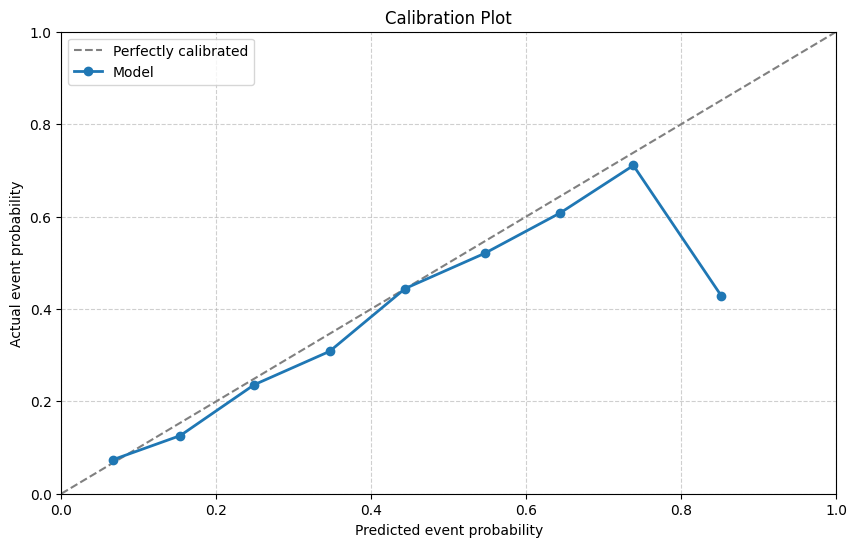

In [49]:
create_calibration_plot(
    data_holdout,
    prob_var="best_logit_pred_proba",
    actual_var="fast_growth",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)


### b) Confusion table with different tresholds

Default: the threshold 0.5 is used to convert probabilities to binary classes

In [73]:
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (no fast growth): ", counts[0])
print(values[1], " (fast growth): ", counts[1])

0.0  (no fast growth):  3166
1.0  (fast growth):  420


Confusion matrix: summarize different type of errors and successfully predicted cases

positive = "yes": explicitly specify the positive case

In [74]:
cm_object1 = confusion_matrix(
    data_holdout_clean["fast_growth"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actual No Fast Growth", "Actual Fast Growth"],
    columns=["Predicted No Fast Growth", "Predicted Fast Growth"],
)
cm1

,Predicted No Fast Growth,Predicted Fast Growth
Actual No Fast Growth,2434,186
Actual Fast Growth,732,234


In [77]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout_clean["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout_clean["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actual No Fast Growth", "Actual Fast Growth"],
    columns=["Predicted No Fast Growth", "Predicted Fast Growth"],
)
cm1b

,Predicted No Fast Growth,Predicted Fast Growth
Actual No Fast Growth,2434,186
Actual Fast Growth,732,234


A sensible choice: mean of predicted probabilities

In [57]:
mean_predicted_fast_growth_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_fast_growth_prob, 3)

np.float64(0.29)

In [79]:
holdout_prediction = np.where(
    data_holdout_clean["best_logit_pred_proba"] < mean_predicted_fast_growth_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout_clean["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual No Fast Growth", "Actual Fast Growth"],
    columns=["Predicted No Fast Growth", "Predicted Fast Growth"],
)
cm2

,Predicted No Fast Growth,Predicted Fast Growth
Actual No Fast Growth,1690,930
Actual Fast Growth,321,645


### c) Visualize ROC (with thresholds in steps) on holdout

What if we want to compare multiple thresholds?

First, discrete ROC (with thresholds in steps) on holdout

In [81]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout_clean["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout_clean["fast_growth"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [82]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

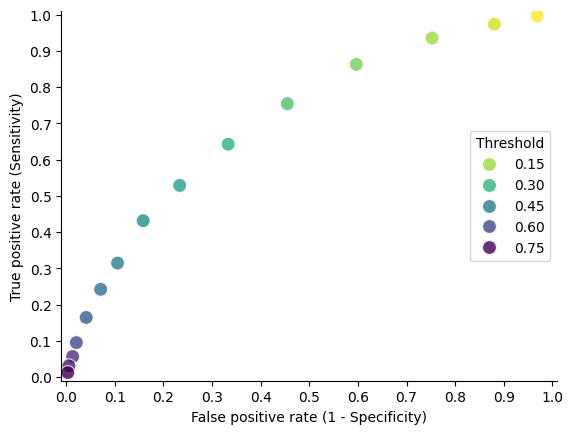

In [83]:
scatter = sns.scatterplot(
    data=tpr_fpr_for_thresholds,
    x="false_positive_rates",
    y="true_positive_rates",
    hue="thresholds",
    palette="viridis_r",
    s=100,
    alpha=0.8,
)

plt.xlabel("False positive rate (1 - Specificity)")
plt.ylabel("True positive rate (Sensitivity)")
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.legend(title="Threshold", loc="center right")
sns.despine()
plt.show()

Continuous ROC on holdout with best model

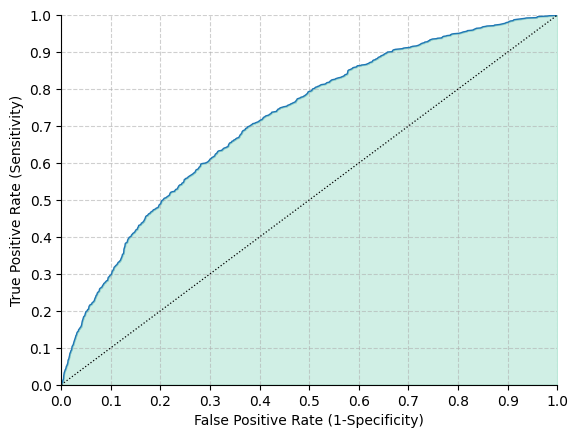

In [87]:
create_roc_plot(data_holdout_clean["fast_growth"], data_holdout_clean["best_logit_pred_proba"])

## 3. We have a loss function

Introduce loss function

Relative cost of of a false negative classification (as compared with a false positive classification)


In [67]:
FP = 1
FN = 10
cost = FN / FP

The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))


In [68]:
prevelance = y_train.sum() / len(y_train)

Draw ROC Curve and find optimal threshold with loss function 

The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

Iterate through:
 1. models
 2. Folds

In [88]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("fast_growth ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["fast_growth"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

ValueError: Input y_true contains NaN.

In [ ]:
fast_growth_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
fast_growth_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
fast_growth_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
fast_growth_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()


In [ ]:
fast_growth_with_lossfnc

Create loss plot based on Fold5 in CV 

In [ ]:
model_to_plot = "M4"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

Create roc plot plot based on Fold5 in CV

In [ ]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)

Let's see our chosen model, M4's holdout expected loss

In [ ]:
best_logit_optimal_treshold = best_thresholds_cv["M4"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["fast_growth"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["fast_growth"])
round(expected_loss_holdout, 3)

CM on holdout

In [ ]:
cm_object3 = confusion_matrix(data_holdout["fast_growth"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actul no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm3

# PREDICTION WITH RANDOM FOREST

In [ ]:
y_train, rfvars_train = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_holdout)

## Graph example for decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

data_for_graph = data_train[["sales_mil", "profit_loss_year", "foreign_management"]]
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41
).fit(data_for_graph, y_train)

plt.figure()
plt.figure(figsize=(11, 11))
plot_tree(
    rf_for_graph,
    feature_names=data_for_graph.columns,
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
)
plt.title("Decision tree")
plt.show()


## Probability forest

Split by gini, ratio of 1's in each tree, average over trees

In [ ]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

5 fold cross validation

In [ ]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [ ]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

Create CV fast_growth table

In [ ]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

Obtain optimal parameter values

In [ ]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_


Get average (ie over the folds) RMSE and AUC

In [ ]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [ ]:
fast_growth.loc["RF", "Number of Coefficients"] = "n.a."
fast_growth.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
fast_growth.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
fast_growth

Extract fold level RMSE and AUC

In [ ]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

Take a look at foldwise RMSE and AUC

In [ ]:
pd.DataFrame(CV_RMSE_folds)

In [ ]:
pd.DataFrame(CV_AUC_folds)

Now use loss function and search for best thresholds and expected loss over folds 

In [ ]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["default"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["default"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


In [ ]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)


In [ ]:
rf_fast_growth = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_fast_growth

Create plots based on Fold5 in CV 

In [ ]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

In [ ]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

Take model to holdout and estimate RMSE, AUC and expected loss 

In [ ]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


ROC AUC  on holdout

In [ ]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)


 Get expected loss on holdout

In [ ]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)


## Final results

In [ ]:
fast_growth["CV treshold"] = best_thresholds_cv
fast_growth["CV expected Loss"] = expected_loss_cv

In [ ]:
fast_growth